In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import glob
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [3]:
from PreprocessingLabeledData import *
from AddingPredProbAndLabel2DF import *
from OverLapReturner import OverLapReturner
from SelectingBestNonOverlappingHits import *

In [4]:
%matplotlib inline

In [5]:
LabeledDataAddressDict = {}
LabeledDataAdds = sorted(glob.glob("../intermediates/*/*e0_labeled.tsv"))
DictOfAdds = {os.path.normpath(x).split(os.sep)[2]:x for x in LabeledDataAdds}
FullNameDict = {"Sc": "S. cerevisiae", "Ec":"E. coli","Mj":"M. jannaschii", "Tb":"T. brucei"}

In [6]:
AddressTbData = DictOfAdds["Tb"]
TbData = pd.read_csv(AddressTbData, sep="\t")
TbData = PreprocessingLabeledData(TbData)
TbDataColumns = ['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
       'alntmscore', 'lddt', 'FracOfPf', 'p_evalue', 'query', 'target',
       'qstart', 'qend', 'tstart', 'tend', 'qlen', 'PredPF', 'PF', 'PFstart',
       'PFend', 'evalue', 'Status']

LabeledData_tb = TbData[TbData["Status"]!=-1]
LabeledData_tb = LabeledData_tb.sample(frac=1, random_state=1).reset_index(drop=True)

NeededColumns = ['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
       'alntmscore', 'lddt', 'FracOfPf', 'p_evalue','query','qstart', 'qend','PredPF', 'PF', "Status"]
X_tb_labeled = LabeledData_tb[NeededColumns].values # The alignments of Tb will have a distinct naming convention
y_tb_labeled = LabeledData_tb['Status'].values # The alignments of Tb will have a distinct naming convention
del LabeledData_tb

UnLabeledData_tb = TbData[TbData["Status"]==-1]
X_tb_unlabeled = UnLabeledData_tb[NeededColumns].values # The alignments of Tb will have a distinct naming convention
y_tb_unlabeled = UnLabeledData_tb['Status'].values # The alignments of Tb will have a distinct naming convention
del UnLabeledData_tb
del TbData


In [7]:
totalNumAli = X_tb_labeled.shape[0] + X_tb_unlabeled.shape[0]
print("There are a total of {} possible alignments between Proteome of interest and Pfam instances".format(totalNumAli))
print("{} percent of the data is labeled as 1 ".format(y_tb_labeled[y_tb_labeled[:]==1].shape[0]*100/totalNumAli))
print("{} percent of the data is labeled as 0 ".format(y_tb_labeled[y_tb_labeled[:]==0].shape[0]*100/totalNumAli))


There are a total of 6805128 possible alignments between Proteome of interest and Pfam instances
9.092099369769386 percent of the data is labeled as 1 
51.60598007855253 percent of the data is labeled as 0 


(1404193, 16)

In [8]:
X_tb_labeled_e_ge_3 = X_tb_labeled[X_tb_labeled[:,9]>=3]
X_tb_labeled_e_s_3  = X_tb_labeled[X_tb_labeled[:,9]<3]
y_tb_labeled_e_ge_3 = y_tb_labeled[X_tb_labeled[:,9]>=3]
y_tb_labeled_e_s_3  = y_tb_labeled[X_tb_labeled[:,9]<3]
del X_tb_labeled
del y_tb_labeled

In [32]:
X_test[X_test[:,-1]==1].shape

(128167, 16)

In [9]:
X_train, X_test_e_ge_3, y_train, y_test_e_ge_3 = train_test_split(X_tb_labeled_e_ge_3, y_tb_labeled_e_ge_3, train_size = 0.9, test_size=0.1, shuffle=False)
X_cv, X_test_e_ge_3, y_cv, y_test_e_ge_3 = train_test_split(X_test_e_ge_3, y_test_e_ge_3, train_size = 0.5, test_size=0.5, shuffle=False)

In [10]:
X_test = np.concatenate((X_tb_labeled_e_s_3, X_test_e_ge_3 ),axis = 0)
y_test = np.concatenate((y_tb_labeled_e_s_3, y_test_e_ge_3 ),axis = 0)

In [11]:
del X_tb_labeled_e_ge_3
del y_tb_labeled_e_ge_3
del X_tb_labeled_e_s_3
del y_tb_labeled_e_s_3
del X_test_e_ge_3
del y_test_e_ge_3

In [12]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
rf.fit(X_train[:,:9], y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [ ]:
#import joblib
#joblib.dump(rf, "./PFAS_RF.joblib", compress=3)

In [13]:
ModelDict = {}
TrainSizes = [0.01] #Add whatever fraction you want to test to this dictionary
ModelDict[1] = rf
for train_size in TrainSizes:
    X_train_frac, X_test_frac, y_train_frac, y_test_frac = train_test_split(X_train,y_train, train_size = train_size, test_size=1- train_size, shuffle=False)
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1)
    rf.fit(X_train_frac[:,:9], y_train_frac)
    ModelDict[train_size] = rf
del X_train_frac, X_test_frac, y_train_frac, y_test_frac

In [14]:
X_dict_orgs = {}
y_dict_orgs = {}
ColumnsOfOtherOrgs = ['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
       'alntmscore', 'lddt', 'FracOfPf', 'p_evalue','PF']
for org in DictOfAdds:
    if org == "Tb":
        continue 
    Data = pd.read_csv(DictOfAdds[org], sep="\t")
    Data = PreprocessingLabeledData(Data)
    print("The summary of the alignments for {}".format(org))
    print("There are total of {} possible alignments between Proteome of {} and Pfam instances".format(Data.shape[0], org))
    totalNum = Data.shape[0]
    print("{} percent of the data is labeled 1 ".format(Data[Data["Status"]==1].shape[0]/totalNum*100))
    print("{} percent of the data is labeled 0 ".format(Data[Data["Status"]==0].shape[0]/totalNum*100))
    Data = Data[Data["Status"]!=-1]
    X_dict_orgs[org] = Data[NeededColumns].values
    y_dict_orgs[org] = Data['Status'].values
    del Data

The summary of the alignments for Ec
There are total of 7585644 possible alignments between Proteome of Ec and Pfam instances
10.97996425880255 percent of the data is labeled 1 
84.56551612493284 percent of the data is labeled 0 
The summary of the alignments for Mj
There are total of 3304388 possible alignments between Proteome of Mj and Pfam instances
8.000664570867585 percent of the data is labeled 1 
79.99559979033938 percent of the data is labeled 0 
The summary of the alignments for Sc
There are total of 6655998 possible alignments between Proteome of Sc and Pfam instances
10.886256275918353 percent of the data is labeled 1 
70.58604885398103 percent of the data is labeled 0 


<Figure size 640x480 with 0 Axes>

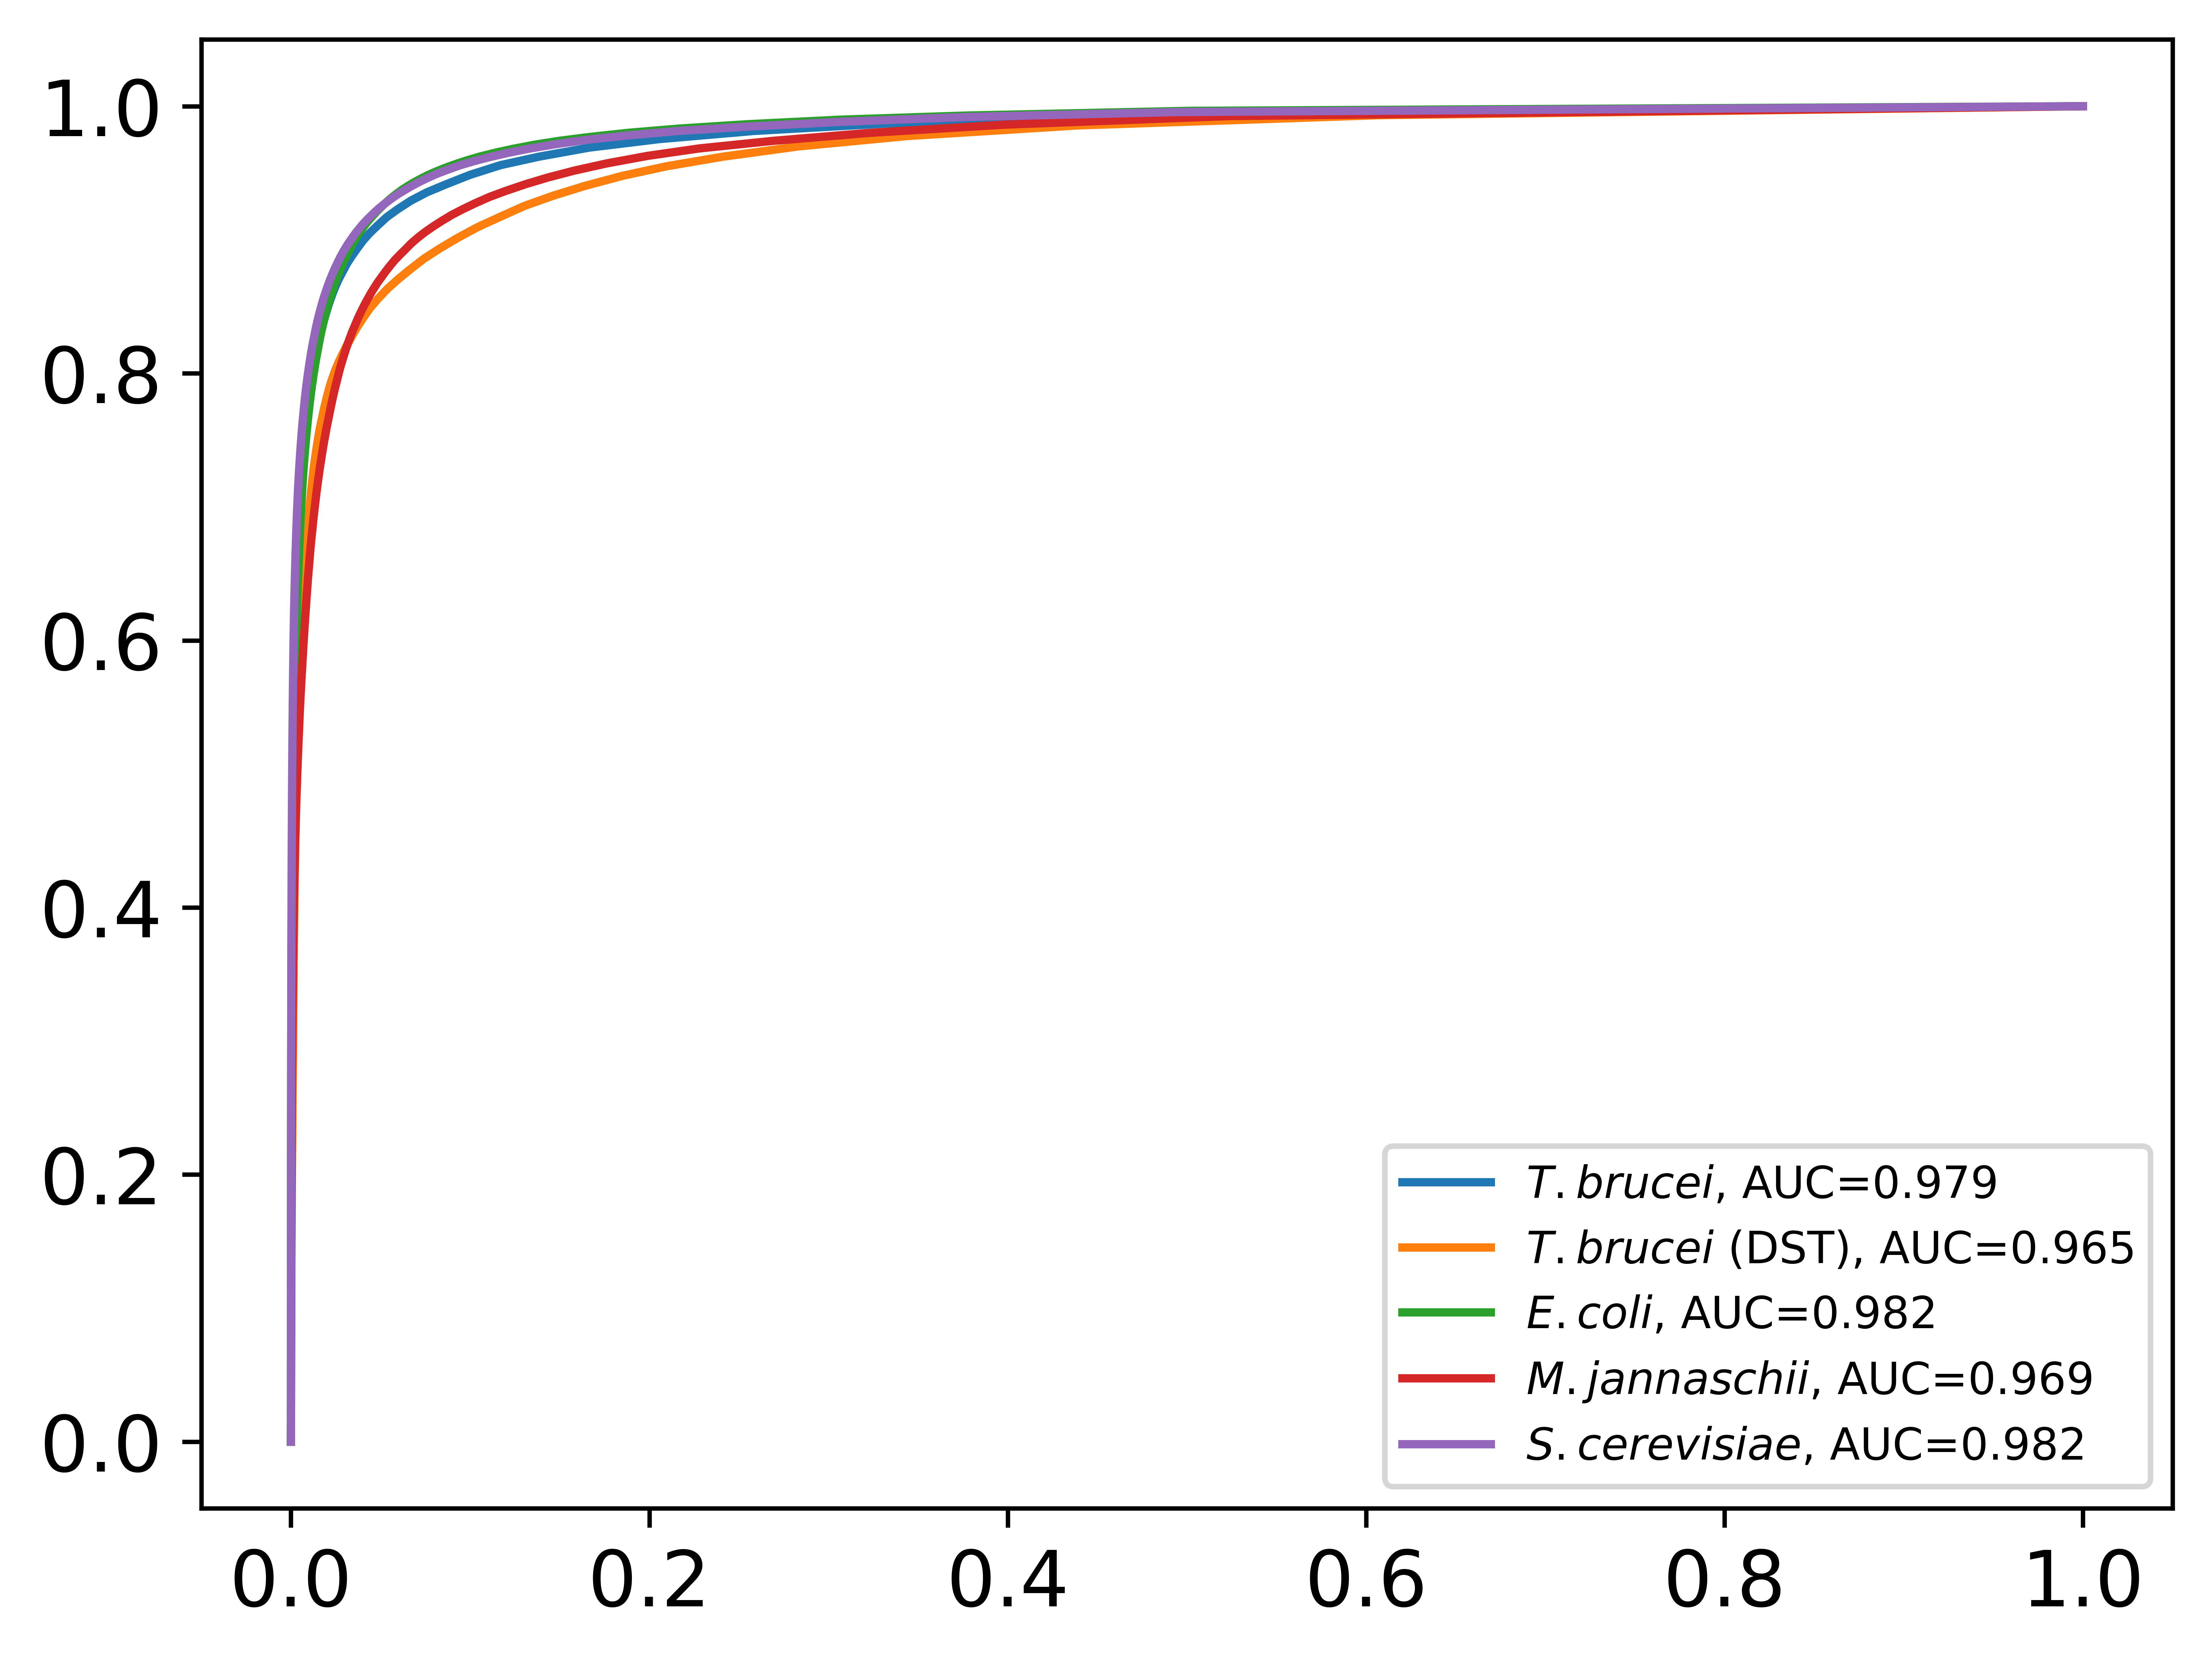

In [15]:
plt.figure(0).clf()
plt.figure(dpi=1200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#add legend
#plt.legend()
ProbDict = {}

for frac in ModelDict.keys():
    model = ModelDict[frac]
    y_pred_prob = model.predict_proba(X_test[:,:9])[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    auc = round(metrics.roc_auc_score(y_test, y_pred_prob),3)
    if frac!= 1:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$ (DST)" +", AUC="+str(auc))
    else:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$" + ", AUC="+str(auc))
        ProbDict["Tb"] = y_pred_prob
   
model = ModelDict[1]
for org in X_dict_orgs.keys():
    y_pred_prob = model.predict_proba(X_dict_orgs[org][:,:9])[:, 1]
   
    fpr, tpr, _ = metrics.roc_curve(y_dict_orgs[org], y_pred_prob)
    auc = round(metrics.roc_auc_score(y_dict_orgs[org], y_pred_prob),3)
    plt.plot(fpr,tpr,label= "$\it{" + FullNameDict[org] + "}$" + ", AUC="+str(auc))
    ProbDict[org] = y_pred_prob

plt.legend( prop={'size': 8})

In [17]:
DF_dict = {}
for org in ProbDict.keys():
    PredProbs = ProbDict[org]
    Preds = (PredProbs>=0.5).astype(int) #
    if org == "Tb":
        X_of_org = X_test
        y_of_org = y_test
        #ACC = (Preds==y_test).sum()/Preds.shape[0]
    else:
        X_of_org = X_dict_orgs[org]
        y_of_org = y_dict_orgs[org]
    Labels = y_of_org #
    #PredPF = X_of_org[:, 16] #
    PF = X_of_org[:, -1] #
    
    orgDF = pd.DataFrame({"PredLabel":Preds, "Label": Labels, "PF":PF, "PredProb": PredProbs})
    #ClanOfS = orgDF[["PredPF"]].merge(PfamClan, left_on="PredPF", right_on="PF")["Clan"]
    #ClanOfQ = orgDF[["PF"]].merge(PfamClan, left_on="PF", right_on="PF")["Clan"]
    #print(ClanOfS.shape)
    #print(ClanOfQ.shape)
    #orgDF["ClanLabel"] = orgDF["Label"]
    #ser = ((orgDF["PredLabel"]==1) & (ClanOfS==ClanOfQ))&(orgDF["Label"]==0)
    #print(ser.sum())
    #nums = ((orgDF["PredLabel"]==1) & (ClanOfS==ClanOfQ))&(orgDF["Label"]==0)
    #print(orgDF[nums])
    #orgDF.loc[nums,"ClanLabel"]= 1
    #print(orgDF[nums])

    DF_dict[org] = orgDF
    
    #print("Accuracy for {} in Pfam Level is {}".format( org, (Preds==orgDF["Label"]).sum()/Labels.shape[0]))
    #print("Accuracy for {} in Clan Level is {}".format( org, (Preds==orgDF["ClanLabel"]).sum()/Labels.shape[0]))

The following cell calculates the accuracy of the classifier on all alignments of each organism

In [18]:
def CalcAccuracy(df):
    CorrectNums = (df["PredLabel"]==df["Label"]).sum()
    SampleSize = df.shape[0]
    accuracy = CorrectNums/SampleSize
    return accuracy


def CalcAUC(df):
    return metrics.roc_auc_score(df["Label"], df["PredProb"])


def CalAUCgroupwise(df):
    return df.apply(lambda x: CalcAUC(x)).mean()



def MeanAccGroupedWise(df):
    return df.apply(lambda x: CalcAccuracy(x)).mean()
    
#from scipy.stats import binom
#def CalcPval(df, ACC):
#    CorrectNums = (df["PredLabel"]==df["Label"]).sum()
#    SampleSize = df.shape[0]
#    p_value = binom.cdf(CorrectNums,SampleSize,ACC)
#    return p_value

In [19]:
for org in DF_dict.keys():
    AllPreds = DF_dict[org]
   # accuracy = CalcAccuracy(AllPreds)
    
    #print("Accuraccy on {} is {}".format(org, accuracy))
    
    #MAGBP = CalcAUC(AllPreds)
    #print("AUC on {} when data is grouped by the Pfam of the query is {}".format(org, MAGBP))
    #AUC_grouped = CalAUCgroupwise(AllPreds.groupby("PF"))
    MAGBPP  = CalcAUC(AllPreds)
    print("AUC on {} when data is grouped by the Pfam of the subject is {}".format(org, MAGBPP))
    
    

AUC on Tb when data is grouped by the Pfam of the subject is 0.9787922068515778
AUC on Ec when data is grouped by the Pfam of the subject is 0.9822229933282812
AUC on Mj when data is grouped by the Pfam of the subject is 0.9692677252491553
AUC on Sc when data is grouped by the Pfam of the subject is 0.9824546156273313


# Best hit attribution benchmarking
The next part is for Evaluating Best Hit attribution, first, we have to predict the probability and the label of each alignment by the trained model, then select the best hit, and continue annotating new domain to the point each newly added domain overlaps less than 10 aminoacids with previously added domains.

In [20]:
#This block is for retrieving the number of annotated Pfams for each organism
PfamAnnotationNums = {}
for org in FullNameDict.keys():
    file = open("../rawinput/{}/Pfam{}.txt".format(org,org))
    NumOfAnnotations = len(file.read().strip().split("\n"))
    PfamAnnotationNums[org] = NumOfAnnotations
    

The next block is for retrieving the Proteins in each organism among the Pfam Seeds


In [21]:
PfamSeedsDict = {}
for org in FullNameDict.keys():
    PfamSeedsInOrg = open("../rawinput/{}/PfamSeeds{}.tsv".format(org,org)).read().strip().split("\n")
    PfamSeedsDict[org] = PfamSeedsInOrg

In [22]:
def Precision(df):
    TotalPreds = df.shape[0]
    CorrectPreds = df[df["Status"]==1].shape[0]
    return CorrectPreds/TotalPreds
def Sensitivity(df, org):
    correctAnns = df[df["Status"]==1]
    return correctAnns.shape[0]/PfamAnnotationNums[org]

In [23]:
model = ModelDict[1]
PrecisionDict = {}
AnnotDict = {}
X_tb = np.concatenate((X_cv, X_test,X_train))

AnnotDFTb = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_tb, model))
AnnotDict["Tb"] = AnnotDFTb


In [24]:
for org in X_dict_orgs.keys():
    AnnotDF = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_dict_orgs[org], model))
    AnnotDict[org] = AnnotDF

In [45]:
X_tb.shape

(4130582, 16)

In [46]:
AnnotDFTb.shape

(5993, 17)

In [ ]:
#np.concatenate((X_cv, X_test,X_train))

In [71]:
temp = AddingPredProbAndLabel2DF(X_tb, model)

In [72]:
print(X_tb.shape)
print(temp.shape)

(4130582, 15)
(596472, 16)


In [73]:
temp.columns

Index(['query', 'PredPF', 'qstart', 'qend', 'RF_prob', 'PredLabel', 'fident',
       'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits', 'alntmscore',
       'FracOfPf', 'p_evalue', 'PF'],
      dtype='object')

In [77]:
ans = SelectingBestNonOverlappingHits(temp)

In [79]:
ans.shape
AnnotDict["Tb"] = ans

In [25]:
for org in AnnotDict.keys():
    annots = AnnotDict[org]
    TruePreds = annots[annots["Status"]==1] 
    print("information on {}".format(org))
    print("{} percent of Annotated Pfams have been correctly annotated".format(100* Precision(annots)))
    print("{} percent of Annotated Pfams have been retrieved correctly".format(100* Sensitivity(annots, org)))
    print("When considering those not among the Pfam Seeds:")
    NotSeedsDF = annots[~annots["query"].isin(PfamSeedsDict[org])]
    print("{} percent of Annotated Pfams have been correctly annotated".format(100* Precision(NotSeedsDF)))
    print("{} percent of Annotated Pfams have been retrieved correctly".format(100* Sensitivity(NotSeedsDF, org)))
    

information on Tb
96.62940096779576 percent of Annotated Pfams have been correctly annotated
86.63973668461999 percent of Annotated Pfams have been retrieved correctly
When considering those not among the Pfam Seeds:
95.6742387626873 percent of Annotated Pfams have been correctly annotated
59.23099940155595 percent of Annotated Pfams have been retrieved correctly
information on Ec
96.56871071853236 percent of Annotated Pfams have been correctly annotated
91.97540850994984 percent of Annotated Pfams have been retrieved correctly
When considering those not among the Pfam Seeds:
95.59043348281017 percent of Annotated Pfams have been correctly annotated
41.38488917650866 percent of Annotated Pfams have been retrieved correctly
information on Mj
93.456980937661 percent of Annotated Pfams have been correctly annotated
85.12435476302205 percent of Annotated Pfams have been retrieved correctly
When considering those not among the Pfam Seeds:
90.9090909090909 percent of Annotated Pfams have bee

In [310]:
for org in FullNameDict.keys():
    PfamAnns = pd.read_csv("../rawinput/{}/Pfam{}.txt".format(org, org),sep="\t", header=None)
    print("The number of total annotations for {} is {}".format(org,PfamAnns.shape[0] ))
    NotSeeds = PfamAnns[~PfamAnns[0].isin(PfamSeedsDict[org])]
    print("The number of annotations for proteins not among Pfam Seeds of {} is {}".format(org,NotSeeds.shape[0] ))

The number of total annotations for Sc is 7924
The number of annotations for proteins not among Pfam Seeds of Sc is 3550
The number of total annotations for Ec is 6181
The number of annotations for proteins not among Pfam Seeds of Ec is 2824
The number of total annotations for Mj is 2131
The number of annotations for proteins not among Pfam Seeds of Mj is 648
The number of total annotations for Tb is 6684
The number of annotations for proteins not among Pfam Seeds of Tb is 4622


In [26]:
model = ModelDict[1]
FeatureImps = model.feature_importances_
FeatureNames = ['fident', 'alnlen', 'nmismatch', 'ngapopen', 'pflen', 'bit score', 'TM-score','lddt', "pfcov"]
SortedFeatures = sorted(zip(FeatureNames, FeatureImps), key=lambda x: x[1], reverse=True)
for item in SortedFeatures:
    print(item[0] + "\t"+ str(item[1]))

lddt	0.2358764697554037
bit score	0.17428008256732638
fident	0.16022745969190963
ngapopen	0.1144385437827204
TM-score	0.08789021626240014
pflen	0.0791716823839584
alnlen	0.061750694882659586
pfcov	0.044005551159475624
nmismatch	0.042359299514146014


# Annotating New Genes in T. brucei

In [27]:
exec(open("AddingPredProbAndLabel2DF.py").read())
exec(open("PreprocessingLabeledData.py").read())
exec(open("SelectingBestNonOverlappingHits.py").read())

In [28]:
PfamAnnDict = {}
PfamsTb = open("../rawinput/Tb/PfamTb.txt")
for line in PfamsTb:
    Gene, Pf, start,end = line.strip().split()
    Intervals = PfamAnnDict.get(Gene, [])
    Intervals.append((int(start), int(end)))
    PfamAnnDict[Gene] = Intervals

In [33]:
X_to_check_Tb = X_tb_unlabeled

In [34]:
model = ModelDict[1]
NewlyAnn = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_to_check_Tb, model), PfamAnnDict)

In [35]:
NewlyAnn.columns

Index(['query', 'PredPF', 'qstart', 'qend', 'RF_prob', 'PredLabel', 'fident',
       'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits', 'alntmscore',
       'FracOfPf', 'p_evalue', 'PF', 'Status'],
      dtype='object')

In [36]:
NewlyAnn.columns
#NewlyAnn = NewlyAnn[['query', 'PredPF', 'qstart', 'qend', 'RF_prob','target', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
#       'alntmscore', 'FracOfPf', 'p_evalue',  'tstart',
#       'tend', 'qlen', 'PF', 'PFstart', 'PFend',
#       'evalue', 'Status', 'PredLabel']]
NewlyAnn = NewlyAnn[['query', 'PredPF', 'qstart', 'qend', 'RF_prob', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
       'alntmscore', 'FracOfPf', 'p_evalue']]

In [39]:
NewlyAnn.columns = ['Query', 'PredPF', 'Qstart', 'Qend', 'RF_prob',
                    #'PFinstance', 
                    'fident', 'alnlen', 'nmismatch', 'ngapopen', 'PFlen', 'bit score',
       'alntmscore', 'pfcov', 'p_evalue',  
                   # 'InstanceStart','InstanceEnd', 
                    #'Qlen'
                   ]

In [40]:
NewlyAnn.to_csv("../predictions/NewPredictionsTb_AgPfam_e0_without_e_value.txt", index=None, sep="\t")

In [41]:
NewlyAnn.groupby(['PredPF'])['PredPF'].count().sort_values(ascending=False)[:10]

PredPF
PF00400    442
PF12799    116
PF00560     79
PF13458     75
PF00076     41
PF13499     35
PF00913     31
PF13570     30
PF13855     29
PF13424     26
Name: PredPF, dtype: int64